<a href="https://colab.research.google.com/github/davanstrien/introduction-to-computer-vision-workshop/blob/main/cv-deep-learning-pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission

Cloning into 'Programming-Historian-Computer-Vision-Lessons-submission'...
remote: Enumerating objects: 3889, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 3889 (delta 20), reused 24 (delta 6), pack-reused 3842
Receiving objects: 100% (3889/3889), 802.33 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (825/825), done.
Checking out files: 100% (2583/2583), done.


In [ ]:
!mv /content/Programming-Historian-Computer-Vision-Lessons-submission/deep-learning/ads_data .

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 204kB 7.5MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


# Computer Vision for the Humanities: an introduction to deep learning for image classification

## Authors:
- Daniel van Strien 
- Kaspar Beelen
- Melvin Wevers
- Thomas Smits
- Katherine McDonough

## Understanding the use of visual advertising using computer vision

- research question 
- basic overview of training a model 
- some considerations along the way


### The Data: Classifying Images from Historical Newspapers 

In these lessons, we will work with a dataset which is derived from the ["Newspaper Navigator" dataset](https://news-navigator.labs.loc.gov/). This is a dataset of extracted visual content for 16,358,041 digitised historic newspaper pages drawn from the [Library of Congress](https://loc.gov/) [Chronicling America collection](https://chroniclingamerica.loc.gov/about/) and places these images into one of seven categories, including photographs and advertisements.

The Newspaper Navigator data was created using an [object detection](https://en.wikipedia.org/wiki/Object_detection) deep learning model. This model was trained on annotations of World War 1-era Chronicling America pages, including annotations made by volunteers as part of the [Beyond Words](http://beyondwords.labs.loc.gov) crowdsourcing project.[^navigator] 

If you want to find out more information about how this dataset was created you may want to read the [journal article](https://arxiv.org/abs/2005.01583) describing this work or look at the [GitHub repository](https://github.com/LibraryOfCongress/newspaper-navigator) which contains the code and training data. We won't be replicating this model in this lesson. Instead, we will use the output of this model as the starting point for creating the data we use in this tutorial. Since the data from Newspaper Navigator is predicted by a machine learning model it will contain errors, for now, we will accept that the data we are working with is imperfect.

### Looking at some examples

Since we're working with images it's useful to look at a few to see what they look like. 

In [ ]:
import pandas as pd
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Living-with-machines/nnanno_example_data/main/ads_sample/sample.csv", index_col=0)

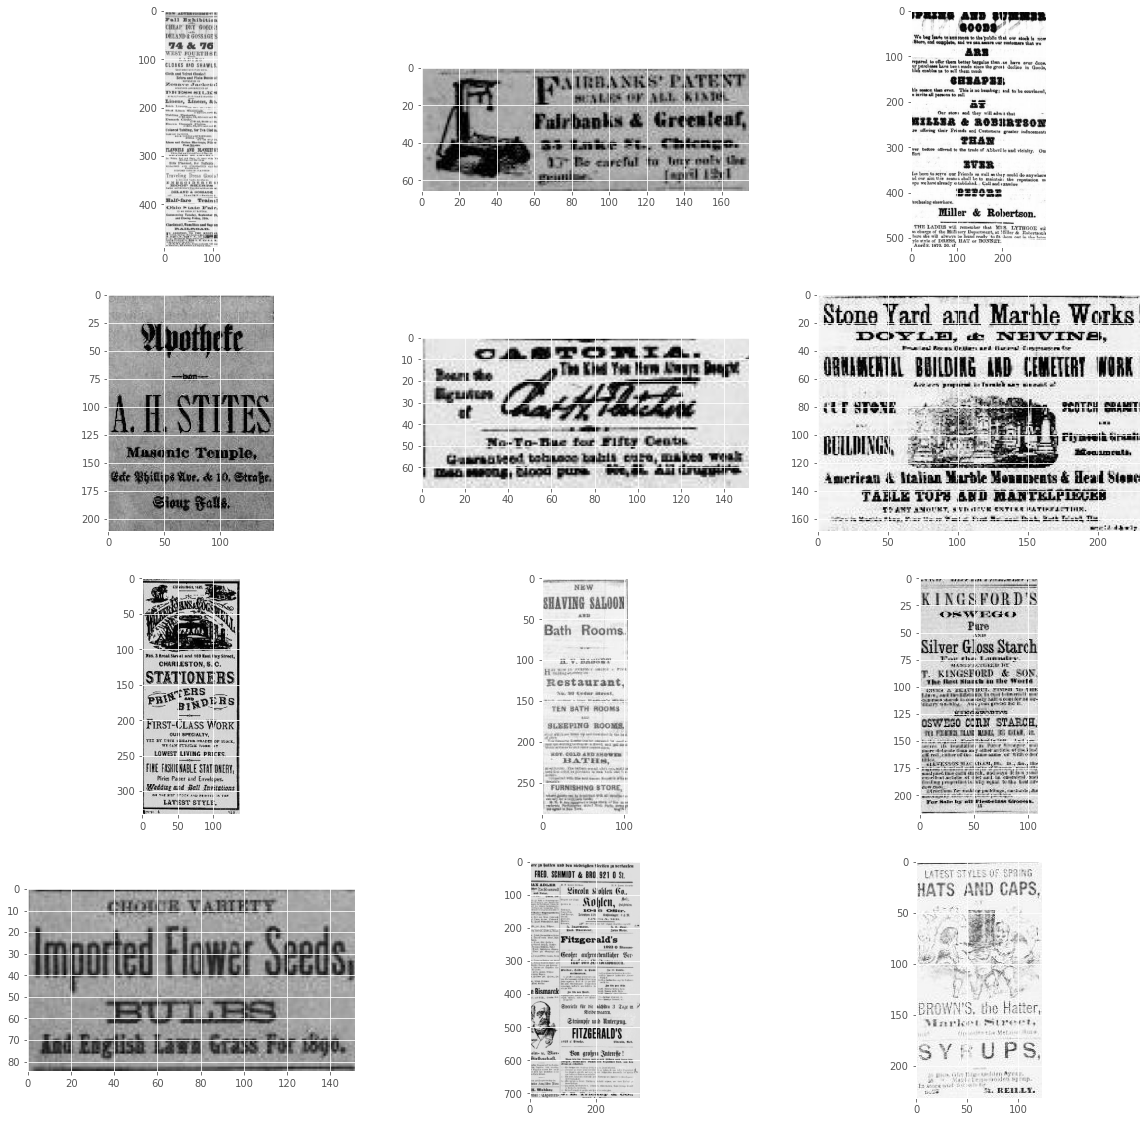

In [ ]:
images = df.sample(12)['url'].to_list()
plt.figure(figsize=(20,20))
columns = 3
for i, image in enumerate(images):
    r = requests.get(image)
    image = Image.open(io.BytesIO(r.content))
    plt.subplot(9 / columns + 1, columns, i + 1)
    plt.imshow(image)

# How can we work with this corpus?

Let's get a sense of the size of this data using a summary pre-prepared. 

In [ ]:
all_years_url = "https://raw.githubusercontent.com/Living-with-machines/nnanno_example_data/main/all_years/all_year_counts.csv"

In [ ]:
df = pd.read_csv(all_years_url, index_col=0)

In [ ]:
df

ads_count  photos_count  ...  headlines_count   total
1850       8841            22  ...            11243   20791
1851      10065            20  ...            12262   22817
1852       8764            22  ...            13524   23009
1853      11517            45  ...            13224   25986
1854      15050           221  ...            15282   31314
...         ...           ...  ...              ...     ...
1946     185139          5945  ...            68275  266410
1947     181223          4188  ...            57018  249721
1948     152987          4282  ...            43432  206869
1949     154510          6015  ...            42904  210587
1950     154961          5630  ...            37854  206217

[101 rows x 8 columns]

In [ ]:
df['ads_count'].sum()

63338192

### Visualize over time

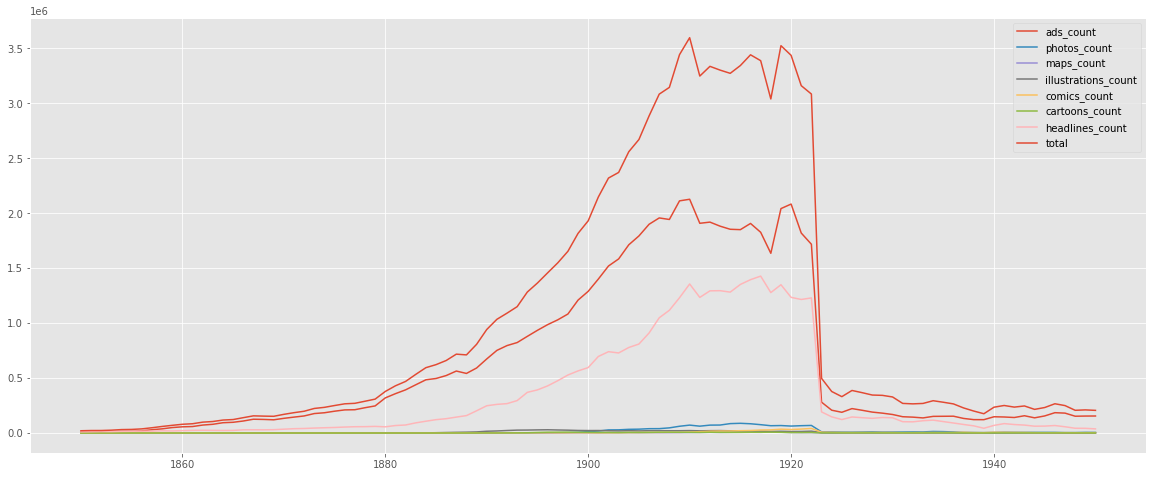

In [ ]:
fig = df.plot(figsize=(20,8))

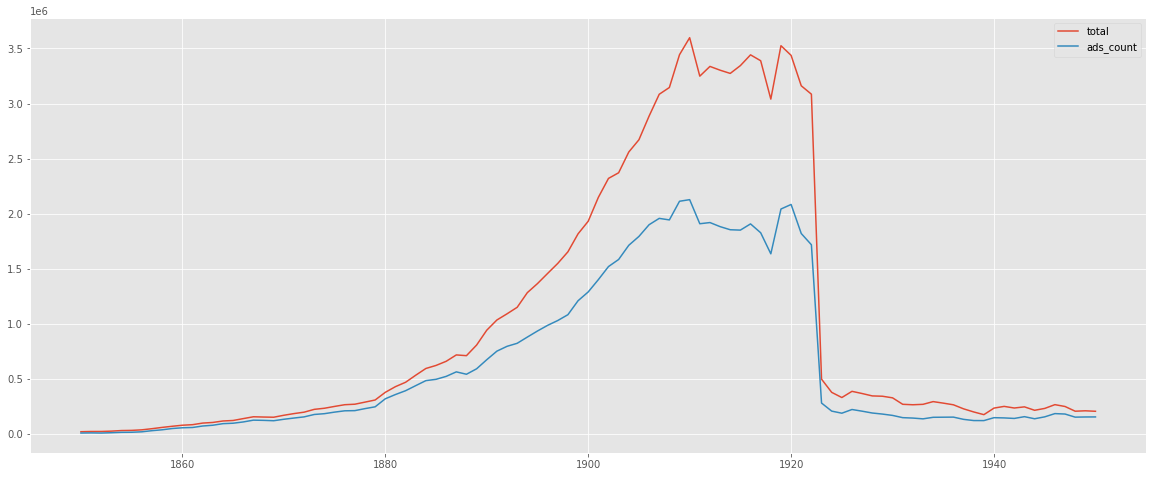

In [ ]:
fig = df[['total','ads_count']].plot(figsize=(20,8))

## Challenges of working at scale 

- what can we do by working at scale?
- what do we need to change? 
- how can machine learning/computer vision help?

## A Quick Introduction to Machine Learning

To contrast machine learning from other computational approaches we'll consider an example of spam detection. 

A rules based approach:

```
count number spam_words in email:
    if number spam_words >= 10:
        email = spam
```

Machine learning approach:

```
emails/
    spam_examples 
    not_spam_examples
```

## Training an Image Classification Model 

Now we have got a very general overview of machine learning, we'll move to our first example of using deep learning for computer vision. In this example we will build an image classifier. This classifier will learn to assign images to one of two categories based on labeled training data. 


### Classifying Newspaper Advertisements 

For our first application of deep learning, we'll focus on classifying images predicted as adverts (remember this data is based on predictions and will contain some errors). More specifically, we'll work with a sample of images of adverts covering the years 1880-5.

#### Detecting if Advertisements Contains Illustrations 
If you look through the advert images, you will see that some of the adverts contain only text, whilst others have some kind of illustration in the advert.

An advert with an illustration:

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/az_gecko_ver01_data_sn84020558_00202192166_1895040701_0061_000_6_98.jpg)

Source: Arizona republican. [volume] (Phoenix, Ariz.) 1890-1930, March 29, 1895, Page 7, Image 7
Image provided by Arizona State Library, Archives and Public Records; Phoenix, AZ
Persistent link: [https://chroniclingamerica.loc.gov/lccn/sn84020558/1895-03-29/ed-1/seq-7/]()


An advert without an illustration:

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/in_ashbel_ver01_data_sn82015679_00295870370_1890020601_0346_001_6_98.jpg) 

Source: The Indianapolis journal. [volume] (Indianapolis [Ind.]) 1867-1904, February 06, 1890, Page 8, Image 8
Image provided by Indiana State Library
Persistent link: [https://chroniclingamerica.loc.gov/lccn/sn82015679/1890-02-06/ed-1/seq-8/]()


Our classifier will be trained to predict which category an advert image belongs to. We might use this classifier to help automate finding adverts with images for further 'manual' analysis. Alternatively, we may use this classifier more directly to help perform research by allowing us to quantify how many adverts contained illustrations for a given year, and if this changed over time, or based on other properties of the newspaper like the place of publication. The intended use of your model will impact the labels you choose to train your model on, and how you choose to assess whether a model is performing sufficiently well. We'll into dig into these issues further as we move through these lessons. 

### Our training data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('ads_data/ads.csv')

## How much data training data do we have?


In [ ]:
df

file          label
0    pst_fenske_ver02_data_sn84026497_00280776129_1...      text-only
1    scu_carlacox_ver01_data_sn84026965_00294551268...      text-only
2    in_england_ver02_data_sn82015464_00202191435_1...      text-only
3    wvu_isner_ver01_data_sn86092518_0041418683A_18...      text-only
4    scu_drinksmall_ver01_data_sn93067705_002372884...      text-only
..                                                 ...            ...
544  mnhi_edina_ver01_data_sn90059522_0017503349A_1...  illustrations
545  vtu_burlington_ver01_data_sn86072143_002807770...      text-only
546  deu_arden_ver01_data_sn85042354_00383343367_18...      text-only
547  kyu_dracula_ver01_data_sn85052141_0020653364A_...  illustrations
548  uuml_hornacek_ver01_data_sn83045555_206539732_...  illustrations

[549 rows x 2 columns]

### Creating our Classifier 

Now we we have defined the goal we want to try to tackle with deep learning, we'll move to developing the code for this task. There are a number of ways we could do this. The Python programming language provides all the functionality we would need to develop code to address this problem from scratch, however we'll almost always want to approach a computer vision problems by building on top of an existing [framework](https://en.wikipedia.org/wiki/Software_framework) or [software library](https://en.wikipedia.org/wiki/Library_(computing)). These libraries will allow you to tackle your problem with much less code compared to creating a solution from scratch and will also be much more efficient and likely to contain less bugs. 

Some libraries/frameworks for deep learning with Python interfaces include: [Keras](https://keras.io/), [Tensorflow](https://www.tensorflow.org/), [Pytorch](https://pytorch.org/), and [fastai](fast.ai). These libraries have slightly different features and aims but all of them implement some of the common building blocks of deep learning. There are advantages and disadvantages to all of these frameworks with some being more suited for particular tasks. 

#### An Introduction to the fastai Library 

In this series of lessons, we will work with [fastai](http://docs.fast.ai/). fastai is a Python library for deep learning "which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches"[^howard]. The library is developed by [fast.ai](https://www.fast.ai/about/) (notice the dot!). fast.ai is a research organisation that aims to make deep learning more accessible. Alongside the fastai library, fast.ai also organises free courses and carries out research. 

There are a few reasons why fastai was chosen for this tutorial: 

- It is focused on making deep learning accessible, both in the API to the library but also in implementing techniques that limit the requirements for a large amount of data or computational resources.
- Many best practices are implemented as 'defaults', helping achieve good results.
- There are different levels at which you can interact with the library depending on how much you need to change lower-level details.
- The library sits on top of Pytorch which makes it relatively simple to use existing Pytorch code. 

Although this tutorial focuses on fastai, many of the techniques shown are applicable across other frameworks too. 

### Creating an Image Classifier in fastai
The next section will outline the steps involved in creating and training a classification model to predict whether an advert is text-only or also contains an illustration. Briefly, the steps will be:
1. Load the data.
2. Create a model.
3. Train this model.

These steps will be covered fairly quickly; don't worry if you feel you are not following everything in this section, the lesson will get back to what is happening in more detail later. 

The first thing we'll do is import the required modules from the fastai library. In this case, we import `vision.all` since we are working on a computer vision task.

In [ ]:
from fastai.vision.all import *

<div class="alert alert-warning">
 Using star imports is generally discouraged in Python. However, fastai uses <a href="https://docs.python.org/3.5/tutorial/modules.html#importing-from-a-package">__all__</a> to provide a list of packages that should be imported when using star import. This approach is useful for exploratory work but you may still want to change your imports to be more explicit. 
</div>

We will also import [Matplotlib](https://matplotlib.org/), a library for creating visualizations in Python. We will ask Matplotlib to use a different [style](https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html) using the `style.use` method. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Loading the Data

There are a number of ways in which data can be loaded using the fastai library. The advert data consists of a folder which contains the image files, and a CSV file which contains a column with paths to the images, and the associated label:

| file | label |
|----|----|
| kyu_joplin_ver01_data_sn84037890_00175045338_1900060601_0108_007_6_97.jpg | text-only |

There are various ways in which we could load this type of data using `fastai`. In this example we'll use `ImageDataLoaders.from_csv`. As the name suggests the `from_csv` method of `ImagDataLoaders` loads data from a CSV file. We need to tell fastai a few things about how to load the data to use this method:

- The path to the folder where images and CSV file are stored.
- The coloumns in the CSV file which contain the labels.
- One 'item transform' ```Resize()``` to resize all the images to a standard size.

We'll create a variable `ad_data` which will be used to store the steps for loading this data:

In [ ]:
ad_data = ImageDataLoaders.from_csv(
    path="ads_data/",  # root path to csv file and image directory
    csv_fname="ads_upsampled.csv/",  # the name of our csv file
    folder="images/",  # the folder where our images are stored
    fn_col="file",  # the file column in our csv
    label_col="label",  # the label column in our csv
    item_tfms=Resize(224, ResizeMethod.Squish),  # resize imagesby squishing so they are 224x224 pixels
    seed=1,  # set a fixed seed to make results more reproducible
)

It is important to make sure that data has been loaded correctly. One way to check this quickly is to use `show_batch()` method on our data. This will display the images and the associated labels for a sample of our data.  

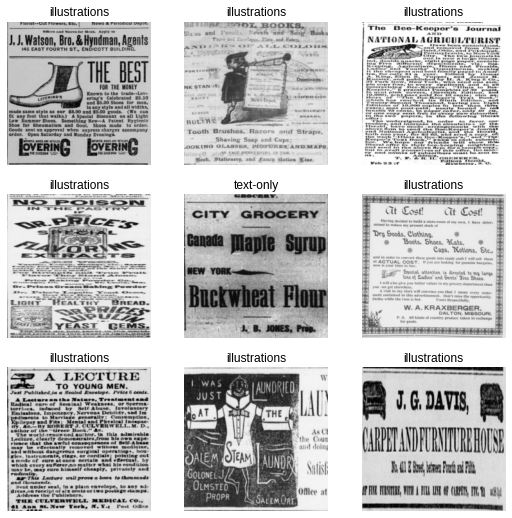

In [ ]:
ad_data.show_batch()

You can see here that the labels have been associated correctly with the labels we want to classify these images into, in this case ```text-only``` and ```illustration```. This is a useful way of checking that your labels and data have been loaded correctly. 

### Creating the Model

Now that fastai knows how to load the data, the next step is to create a model which will be trained on this data. To create a model suitable for computer vision we will use a function `cnn_learner`. This function will create a ['Convolutional  Neural Network'](https://en.wikipedia.org/wiki/Convolutional_neural_network), a type of deep learning model often used for computer vision applications. To use this function you need to pass (at a minimum):

- The data the model will use as training data.
- The type of model you want to use.

This is already sufficient for creating a computer vision model in fastai, but you will usually also want to pass some metrics you want to track during training. This will allow you to get a better sense of how well your model is performing on the task you are training it on. In this example, we'll use `accuracy` as the metric. 

Let's create this model and assign it to a new variable `learn`

In [ ]:
learn = cnn_learner(
    ad_data,  # the data the model will be trained on
    resnet18,  # the type of model we want to use
    metrics=accuracy,  # the metrics to track
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Training the Model 
Although we have created a `cnn_learner` model, we haven't actually trained the model yet. This is done using a `fit` method. Training is the process which allows the computer vision model to 'learn' how to predict the correct labels for the data. There are different ways we can now train (fit) this model. To start with, we'll use the `fine_tune` method. In this example the only thing we'll pass to the fine tune method is the number of epochs to train for.  Each pass through the entire dataset is an 'epoch'. The amount of time the model takes to train will depend on where you are running this code and the resources available. Again, we will cover the details of all of these components below.

In [ ]:
learn.fine_tune(5)

When you run this method you will see a progress bar showing how long the model has been training and the estimated remaining time, alongside a table which displays some other information about the model, this includes our tracked metric, accuracy. You can see that in this example we got an accuracy >90%. When you run the code yourself the score you get will be slightly different. 

### Results 
While deep learning techniques are commonly perceived as needing large amounts of data and extensive computing power, our example shows that for many applications smaller datasets suffice.  In this example, we could have potentially used other approaches; the aim here was not to show the best solution with this particular dataset but to give a sense of what is possible to do with a limited number of labeled examples. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

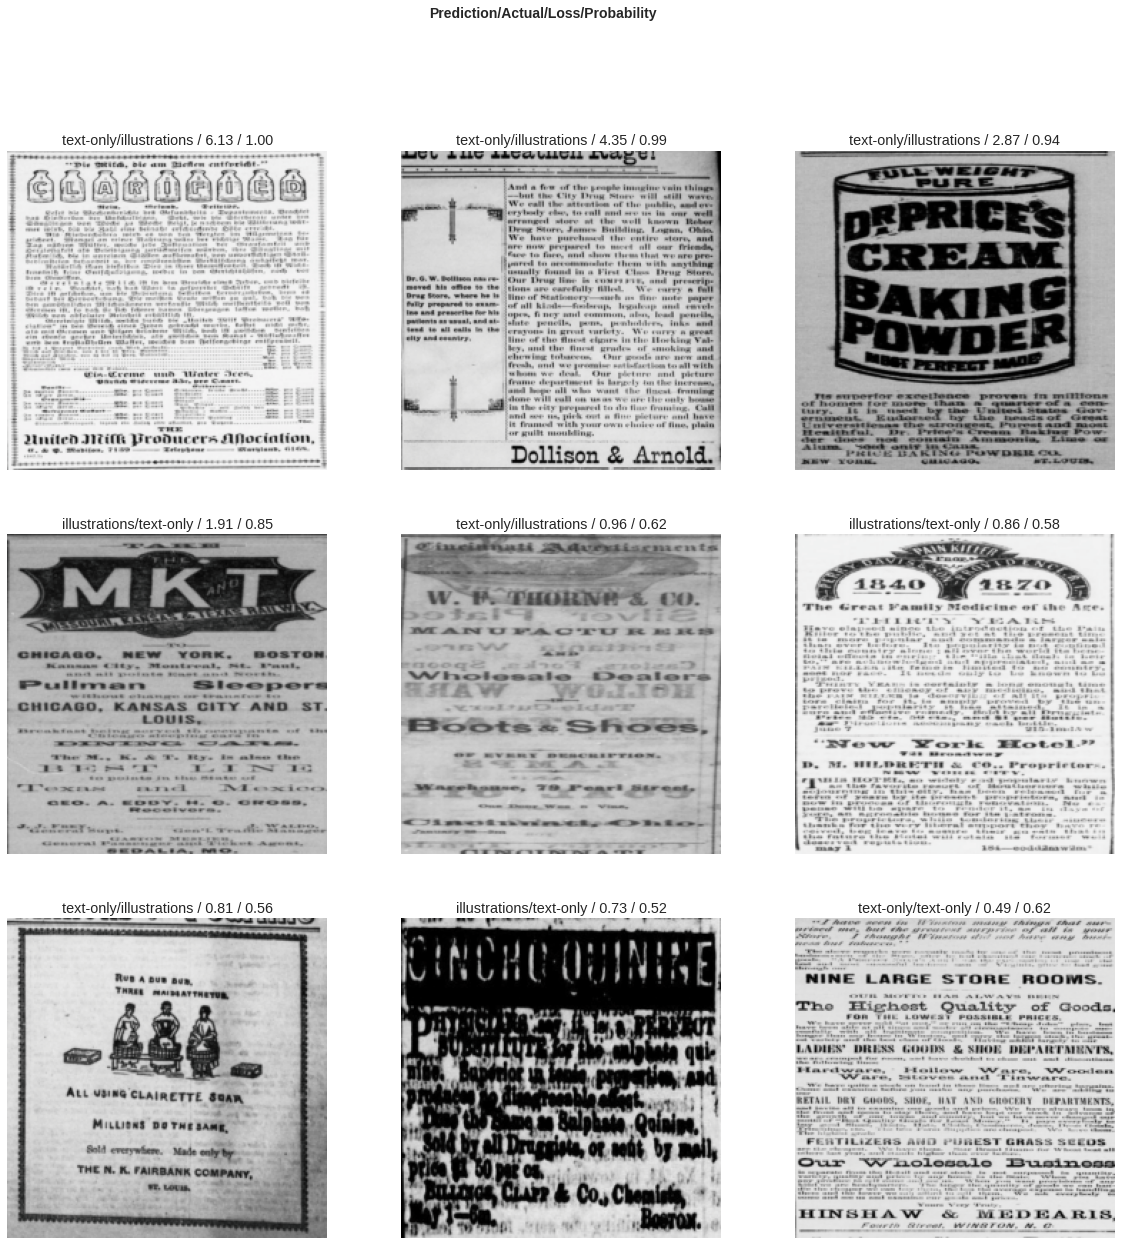

In [ ]:
interp.plot_top_losses(9, figsize=(20,20))

# How 'smart' is our model?

In [ ]:
!wget -O cat.png https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png

--2021-05-06 16:17:39--  https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png
Resolving icatcare.org (icatcare.org)... 142.93.47.206
Connecting to icatcare.org (icatcare.org)|142.93.47.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1246129 (1.2M) [image/png]
Saving to: ‘cat.png’

cat.png             100%[===================>]   1.19M  1.45MB/s    in 0.8s    

2021-05-06 16:17:41 (1.45 MB/s) - ‘cat.png’ saved [1246129/1246129]



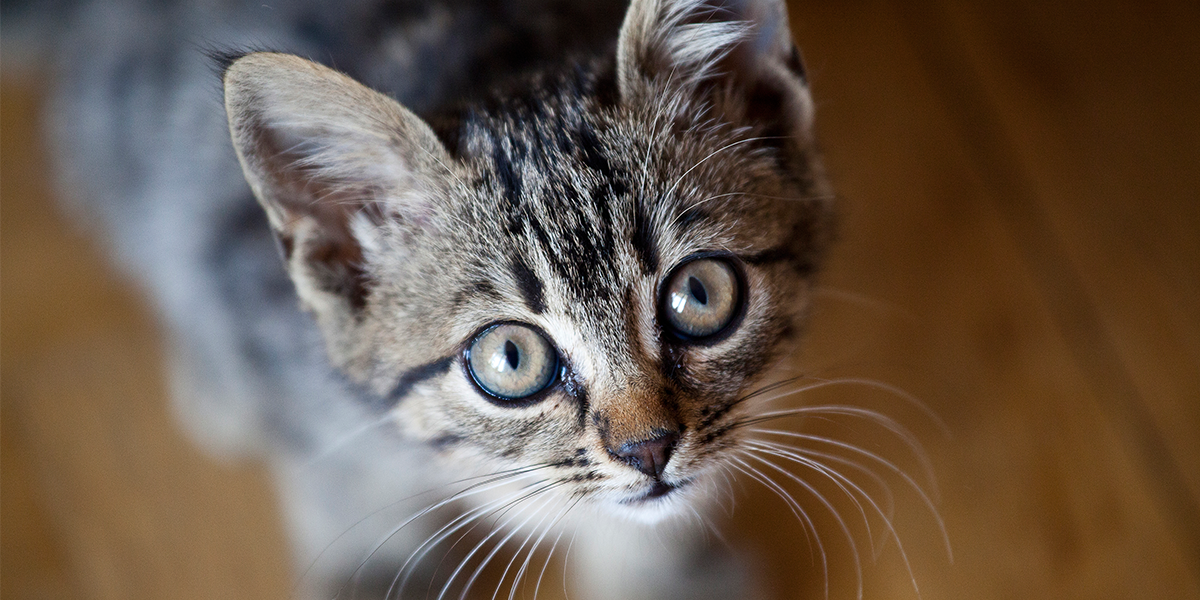

In [ ]:
Image.open('cat.png')

In [ ]:
learn.predict('cat.png')

('illustrations', tensor(0), tensor([0.8959, 0.1041]))

Maybe cut?

In [ ]:
df = pd.read_csv("ads_data/ads_upsampled.csv", index_col=0)

In [ ]:
test_data = learn.dls.test_dl(df.file)

In [ ]:
preds = learn.get_preds(with_decoded=True)

# Computer Vision using Deep Learning

Now that we have an overview of the process we'll go into more detail about how this process works.

## The Workflow of a Supervised Computer Vision Problem 
This section will start to dig into some of the steps involved in the process of creating a deep learning based computer vision model. This process involves a range of steps, only some of which are directly about training models. A high level illustration of a supervised machine learning pipeline might look like this: 

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/deep-learning-pipeline-simple.png?token=ACEUI5KKIGGPQPG2MXCNVWC7SLJEY)

We can see that there are quite a few steps before and after the training the model part. Before we get to the stage of training a model we will need data. In this lesson, data has already been prepared but it is likely that there will usually not be a dataset that helps you tackle your problem exactly. As a result, you will often have to create this data yourself. The process of getting access to data will vary depending on the type of images you are interested in working with, and where those images are currently held. Some heritage collections are already making bulk collections of images data available, whilst others largely make images available only via a 'viewer'. The increasing adoption of the [IIIF standard](https://iiif.io/) is making the process of working with images held by different institutions simpler. 

Once you have a collection of images to work with, the next step if using supervised learning will be to create some labels for this data. Once you have either created or accessed a labelled dataset the next step is to train the model. This process will be discussed in much more detail below. Once a model has been trained you will get out some predictions. These predictions are 'scored' using a range of potential metrics, some of which we'll explore later on. 

Once a model has reached a satisfactory score, the outputs of the model may be used for a range of activities under the heading of 'interpretation'. Once we have predictions from a deep learning model there are different options for what to do with these. They could be used directly for making decisions for example automating where images are displayed in a web collection, but it often likely that the predictions will be fed back to a human for further analysis. This will particularly be the case if the intended use of the deep learning model is to explore some historical phenomena. 

## Training a Model

Zooming in on the deep learning part of the workflow, what does the training process look like? 

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/training-loop.jpg)

A high-level summary of the training loop for supervised learning; start with some images and labels, do some preparation to make the input suitable for a deep learning model, pass the data through the model, make predictions for the labels, calculate how wrong the predictions are, update the model with the aim of generating better predictions next time. This process is repeated a number of times. During this training loop metrics are reported which let the human training the model evaluate how well the model is doing.

This is obviously a very high-level summary. Let's look at each step in the training loop, step-by-step. The next section will show these steps using code so don't worry too much if it doesn't all sink in during this section. 

### Input Data

Starting with the inputs to the model, we have images and labels. Although deep learning takes some inspiration from how human cognition works, the way a computer 'sees' is very different from a human. All deep learning models take numbers as inputs. Since images are stored on a computer as a matrix of pixel values, this process is relatively simple for computer vision models. Alongside these images we have a label(s) associated with each image.  Again, these are represented as numbers inside the model. 

#### How Much Data?
It is often believed that you need huge amounts of data to train a useful deep learning model, however, this is not always the case. We assume that if you are trying to use deep learning to solve a problem, you have enough data to justify not using a manual approach. The real problem is usually the amount of labelled data you have. It is not possible to give a definitive answer  to "how much data?", since the amount of training data required is dependent on a broad range of factors. There are a number of things which can be done to reduce the amount of training data required, some of which we will cover in this lesson. 

The best approach will likely be to create some initial training data and see how well your model does on this. This will help give you a sense of whether a problem is going to be possible to tackle. Furthermore, the process of annotating your data is valuable in itself.

#### Preparing Mini Batches
Usually, when we use deep learning it is not possible to pass all of your data into the model in one go. Instead, data is split into batches which contain a subset of the data. When using a GPU data is usually loaded into GPU memory one batch at a time. The size of this batch can have some impact on the training process but often the size of your batch is determined by the computational resources you have available, and the size of your images. 

The reason we use a GPU for training our model is that it will almost always be much quicker to train a model on a [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) compared to a [CPU](https://en.wikipedia.org/wiki/Central_processing_unit). The reason for this is that a GPU is able to perform many calculations in parallel. As a result, GPUs can be much faster for doing computation which requires many parallel calculations, which includes training deep learning models. 

Before we can create a batch and load it onto the GPU we usually need to make sure the images are all the same size. This allows the GPU to run operations in parallel effectively. 
Once a batch has been prepared, we may want to do some additional transformations on our images to reduce the amount of training data required. We will cover some of these in more detail below.

### Creating a Model 

Once we have prepared data so it can be loaded one batch at a time, we pass it to our model. We already saw one example of a model in our first example `resnet18`. A deep learning model architecture defines how data and labels are passed through a model, In this lesson, we focus on a subset of deep learning model called ['Convolutional Neural Network'](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN). 

<img src='https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/3-layer-network.png' width="800px"> 


This diagram gives a crude overview of the different components of a CNN model. In this type of model, an image is passed through several layers, before predicting an output label for the image ('text only' in this diagram). The layers of this model are updated during training so that they "learn" which features of an image predict a particular label. So for example, the CNN we trained on adverts will update the parameters known as "weights" for each layer, which then produces a representation of the image that is useful for predicting whether an advert has an illustration or not. 

[playground.tensorflow.org]() is a useful tool for helping to develop an intuition about how these layers capture different features of input data, and how these features, in turn, can be used to classify the input data in different ways. 

The power in CNNs and deep learning comes from the ability of these layers to encode very complicated patterns in data.[^universal] The challenge on a practical level is updating these weights effectively. 
 
#### Using an Existing Model? 

When considering how to create our model we have various options about what model to use. One option is to use an existing model which has already been trained on a particular task. You might for example use the [YOLO](https://pjreddie.com/darknet/yolo/) model. This models is trained to predict [bounding boxes](https://computersciencewiki.org/index.php/Bounding_boxes) for a number of different types of object on an image. Although this could be a valid starting point there are a number of limitations to this approach for working with historical material, or for humanities questions. Firstly, the data these models were trained on might be very different from the data you are using. This can impact the performance on this model on your data, and result in biases towards images in your data which are most similar to the training data used to train your model. Another issue is that if you use an existing model without any modification you are restricted to identifying the labels that the original model was trained on. 

Alternatively, you might start from scratch with a new model. Although it is possible to directly define a CNN model yourself by defining the layers you want your model architecture to include, this is usually not where you would start. It is often best to start with an existing model architecture. The development of new model architectures is an active area of research with models proving to be well suited for a range of tasks and data. These models are often then incorporated into deep learning frameworks.

Often, we want a balance between starting from scratch and leveraging existing models. In this lesson, we show an approach which uses existing model architectures but modifies the model slightly to allow it to predict new labels. This model is then trained on new example data so it becomes more suited to the task we want it to perform. This is a technique known as ['transfer learning'](https://en.wikipedia.org/wiki/Transfer_learning) which will be exploring further in this lesson. 

## Someone else's model? 

Exploring the predictions made by the [Google Cloud Vision](https://cloud.google.com/vision) API service or [Azure Computer Vision](https://azure.microsoft.com/en-gb/services/cognitive-services/computer-vision/#features)




## Training 

Once a model has been created and data prepared, the training process can begin. Let's look at the steps of a training loop: 

1. A model is passed data and labels, one batch at a time. Each time an entire dataset has been passed through a model is known as an 'epoch'. The number of epochs used to train a model is one of the variables that you will need to control.

2. The model makes predictions for these labels based on the given inputs, using a set of internal weights. In this CNN model, the weights are contained within the layers of the CNN. 

3. The model calculates how wrong the predictions are, by comparing the predictions to the actual labels. A ['loss function'](https://en.wikipedia.org/wiki/Loss_function) is used to calculate how 'wrong' the model was in its predictions.

4. The model changes internal parameters to try to do better next time. The loss function from the previous step returns a 'loss value', often just referred to as the 'loss', which is used by the model to update the weights. 

A 'learning rate' is used to determine how much a model should update based on the calculated loss. This is another one of the important variables that can be manipulated during the training process. In a later lesson, we will see one potential way of trying to identify a suitable learning rate for your model. 

### Validation Data

When we train a deep learning model we usually do so to make predictions on new unseen data which doesn't contain labels. For example for our ad classifier, we might want to use this classifier across all of the advert images for a particular time period in order to count how many of each type of advert (illustrated or not) appeared in this corpus. We, therefore, don't want a model that only does well at learning how to classify the training data it is shown. This is why we almost always use some form of 'validation data'. This is data which is used to check that the weights a model is learning on the training data also translates to new data. In the training loop, the validation data is only used to 'test' the predictions of the model, it is not directly used by the model to update the weights. This helps to ensure we don't end up 'overfitting' our model. 'Overfitting' refers to when a model becomes very successful at making predictions on the training data but these predictions don't generalize beyond the training data. In effect, the model is 'remembering' the training data rather than learning more general features which will help make correct predictions on new data. A validation set helps prevent this by allowing you to see how well the model is doing on data it hasn't learned from. Sometimes an additional split is made of the data which is used to make predictions only at the end of training a model. This is often known as a 'test' set. A test set is often used to validate model performance for data science competitions, such as those hosted on [kaggle](https://www.kaggle.com/), and to validate the performance of models created by external partners. This helps ensure a model is robust in situations where validation data has deliberately or accidentally been used to 'game' the performance of a model. 

## **Labels?**

- How do we choose our labels?
- Who assigns the labels?
- What abstractions make sense? 
- What abstractions can our models learn?

https://excavating.ai/


### Working with model predictions 

In [ ]:
url = "https://gist.github.com/davanstrien/5055852f7cb0dd57d75c01a969bf8696/raw/106f3b26eaf8da8885b50f7b60dc457352194df7/full.json"

### Some other examples
- What else can be done?
- Practical tasks 
- Research tasks